<a href="https://colab.research.google.com/github/develops20/Voice-to-Voice-translator/blob/main/Ensemble_Modeling_for_Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [1]:
!pip install -q hillclimbers

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [5]:
!pip install -q category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [73]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from hillclimbers import climb_hill, partial
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

# Global variables
oof = {}
test_pred = {}
NUM_FOLD = 5
target = 'loan_status'

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>

In [70]:
# Define dataset paths (Make sure these paths are correct)
train_path = "/content/sample_data/LoanApprovalPrediction/train.csv"
test_path = "/content/sample_data/LoanApprovalPrediction/test.csv"
original_path = "/content/sample_data/LoanApprovalPrediction/credit_risk_dataset.csv"
sample_submission_path = "/content/sample_data/LoanApprovalPrediction/sample_submission.csv"

In [71]:
# Load datasets
train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
original = pd.read_csv(original_path)
sample_submission = pd.read_csv(sample_submission_path)

In [72]:
# Display the first few rows
print("Train Data:")
display(train.head())

print("Test Data:")
display(test.head())

print("Original Data:")
display(original.head())

Train Data:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


Test Data:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


Original Data:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

In [74]:
# Check for missing values
print("Missing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())
print("\nMissing values in original:\n", original.isnull().sum())

# Ensure target column exists in train & original datasets
target = "loan_status"

if target not in train.columns:
    raise ValueError(f"❌ ERROR: '{target}' not found in train dataset!")

if target not in original.columns:
    raise ValueError(f"❌ ERROR: '{target}' not found in original dataset!")

# Print column types
print("\nTrain Data Types:\n", train.dtypes)
print("\nTest Data Types:\n", test.dtypes)
print("\nOriginal Data Types:\n", original.dtypes)

Missing values in train:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Missing values in test:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Missing values in original:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent     

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [77]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<Figure size 800x500 with 0 Axes>

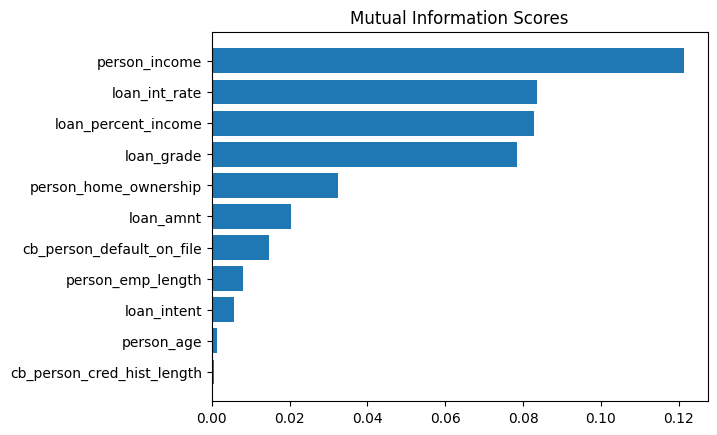

<Figure size 800x500 with 0 Axes>

In [78]:
X_ = train.copy()
y_ = X_.pop("loan_status")

for col in X_.select_dtypes("object"):
    X_[col], _ = X_[col].factorize()

discrete_features = X_.dtypes == int

mi_scores = mutual_info_classif(X_, y_, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_.columns)
mi_scores = mi_scores.sort_values(ascending=True)

width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))

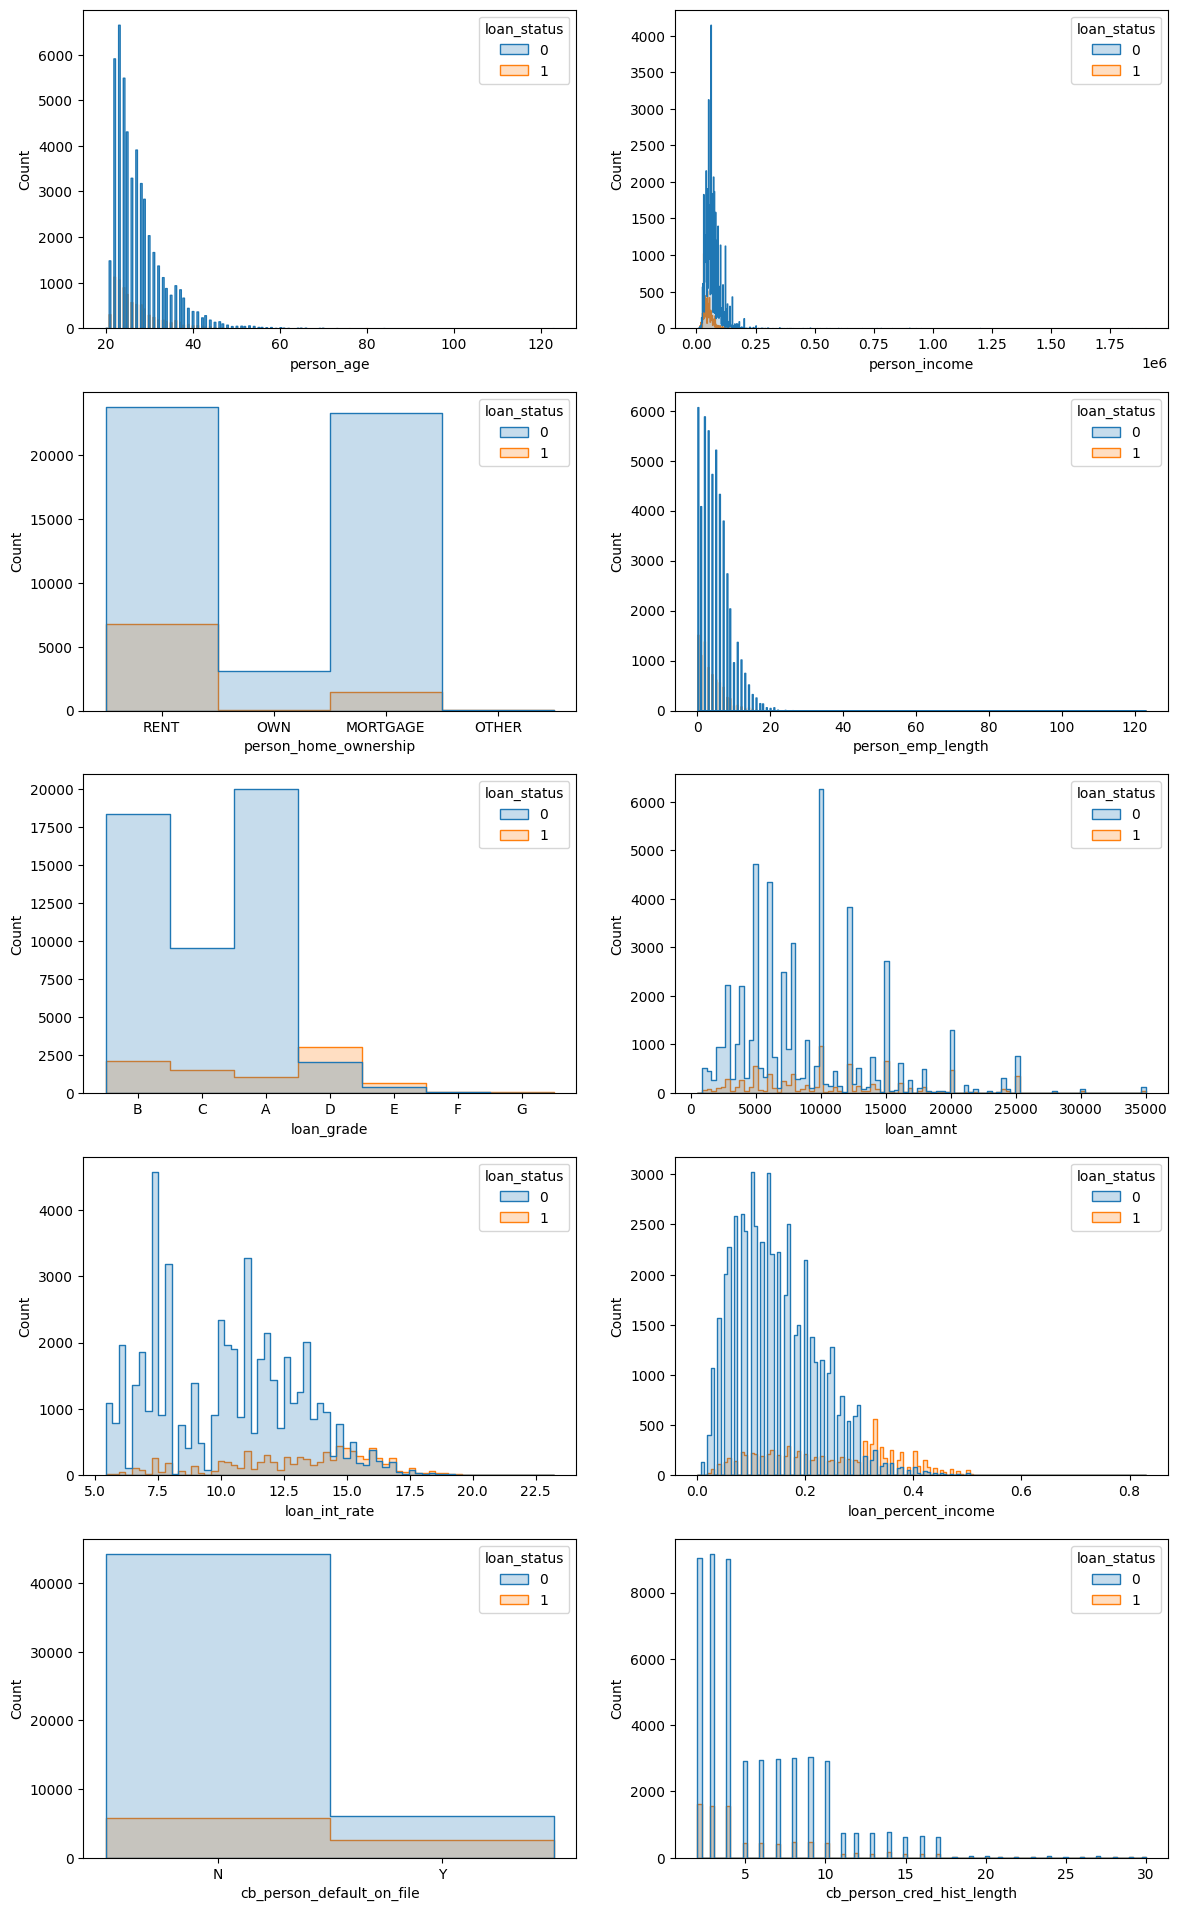

In [79]:
f, axes = plt.subplots(5, 2, figsize=(14, 24))
col = test.columns.tolist()
col.remove('loan_intent')
j = 0
for i in range(0, 10, 2):
    sns.histplot(data=train, x=col[i], element="step", hue="loan_status", ax=axes[j, 0])
    sns.histplot(data=train, x=col[i+1], element="step", hue="loan_status", ax=axes[j, 1])
    j = j + 1

plt.show()

In [90]:
# ✅ STEP 1: Preprocess Data
def preprocess_data(label):
    print(f"\n🔹 Preprocessing Data for: {label}")

    train_copy, test_copy, original_copy = train.copy(), test.copy(), original.copy()

    # Identify categorical columns
    if label in ['cb', 'et', 'rf', 'knn', 'mlp']:
        cat_cols = test_copy.columns.tolist()
    elif label in ['xgb', 'lgbm', 'dart', 'goss']:
        cat_cols = list(test_copy.select_dtypes(include=['object', 'category']).columns)
    else:
        cat_cols = []

    # Convert categorical columns using Label Encoding
    label_encoders = {}

    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        for df in [train_copy, test_copy, original_copy]:
            df[col] = label_encoders[col].fit_transform(df[col])

    # Drop target column from training data
    X = train_copy.drop(columns=[target])
    y = train_copy[target]
    X_original = original_copy.drop(columns=[target])
    y_original = original_copy[target]

    print(f"✅ Data Preprocessed: X shape={X.shape}, y shape={y.shape}")

    return X, y, X_original, y_original, test_copy

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Cross Validation</p>

In [89]:
# ✅ STEP 2: Cross-Validation Function
def cross_validation(model, label):
    print(f"\n🔹 Running Cross-Validation for: {label}")

    # Preprocess data
    X, y, X_original, y_original, test_copy = preprocess_data(label)

    val_scores = []
    test_preds_model = []
    oof_model = np.zeros(len(y))

    skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

    for Fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"\n➡️ Training Fold {Fold+1}/{NUM_FOLD}")

        # Extract training and validation data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add original dataset to training
        X_train = pd.concat([X_train, X_original], axis=0)
        y_train = pd.concat([y_train, y_original])

        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]  # Predict probabilities

        # Calculate ROC AUC score
        roc_auc_score_ = roc_auc_score(y_val, y_pred)
        print(f"✔️ Fold {Fold+1} ROC AUC: {roc_auc_score_:.5f}")

        val_scores.append(roc_auc_score_)
        oof_model[val_index] = y_pred

        # Predict on test set
        test_preds_model.append(model.predict_proba(test_copy)[:, 1])

    # Store results
    oof[label] = oof_model
    test_pred[label] = np.mean(test_preds_model, axis=0)

    print(f"\n📊 Final Metrics for {label}:")
    print(f"Mean ROC AUC: {np.mean(val_scores):.5f}")
    print(f"Std Dev ROC AUC: {np.std(val_scores):.5f}")

    # Generate plots
    plt.figure(figsize=(12, 6))

    #Sub plot 1 Calibration curve
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Calibration", fontsize=14)
    CalibrationDisplay.from_predictions(y, oof_model, n_bins=10, strategy="quantile", ax=ax1)

    # Subplot 2: Histogram
    ax2 = plt.subplot(1, 2, 2)  # Creates the second subplot
    ax2.set_title("Histogram", fontsize=14)  # Correctly set the title
    ax2.hist(oof_model, bins=10, color="blue", edgecolor="black")
    ax2.set_xlabel("Predicted Probabilities")
    ax2.set_ylabel("Frequency")

    # Add overall title and adjust layout
    plt.suptitle(label, fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Lightgbm</p>


🔹 Running Cross-Validation for: lgbm

🔹 Preprocessing Data for: lgbm
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.96559

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.96334

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.96559

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.96514

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.96440

📊 Final Metrics for lgbm:
Mean ROC AUC: 0.96481
Std Dev ROC AUC: 0.00085


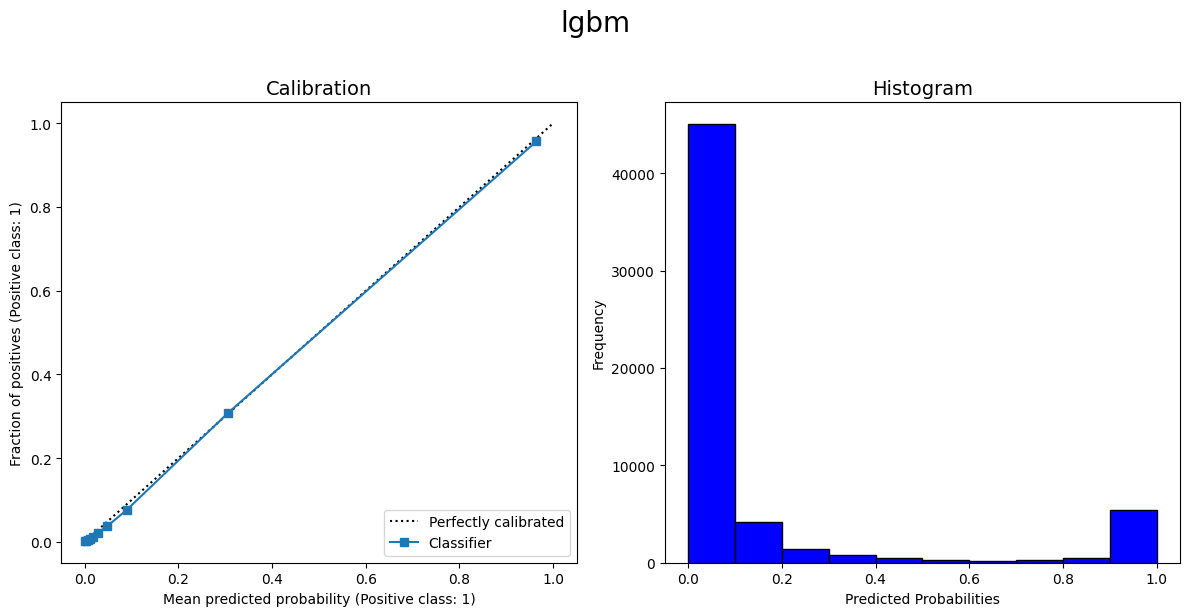

CPU times: user 4min 27s, sys: 1.33 s, total: 4min 28s
Wall time: 4min 29s


In [91]:
%%time

params_lgbm = {

    'verbose': -1,
    'random_state': 1,
    'objective': 'binary',
    'n_estimators': 4100,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 8,
    'max_bin': 5000,
}

model_1 = LGBMClassifier(**params_lgbm)

cross_validation(model_1, 'lgbm')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Dart</p>


🔹 Running Cross-Validation for: dart

🔹 Preprocessing Data for: dart
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.96441

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.96155

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.96457

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.96381

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.96348

📊 Final Metrics for dart:
Mean ROC AUC: 0.96356
Std Dev ROC AUC: 0.00108


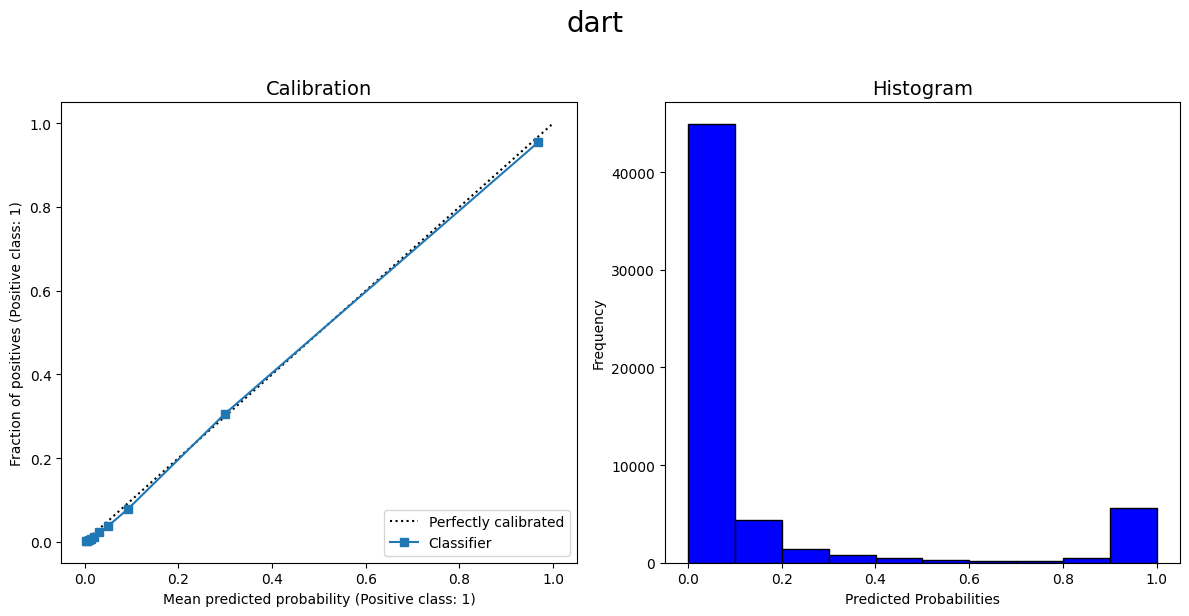

CPU times: user 9min 54s, sys: 856 ms, total: 9min 54s
Wall time: 9min 57s


In [92]:
%%time

params_dart = {

    'verbose': -1,
    'random_state': 1,
    'boosting': 'dart',
    'n_estimators': 600,
    'learning_rate': 0.1,
    'colsample_bytree': 0.6,
    'num_leaves': 85,
    'min_data_in_leaf': 30,
    'max_bin': 1995,
    'objective': 'binary',
}

model_2 = LGBMClassifier(**params_dart)

cross_validation(model_2, 'dart')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">XGBoost</p>


🔹 Running Cross-Validation for: xgb

🔹 Preprocessing Data for: xgb
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.96577

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.96424

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.96638

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.96546

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.96458

📊 Final Metrics for xgb:
Mean ROC AUC: 0.96529
Std Dev ROC AUC: 0.00078


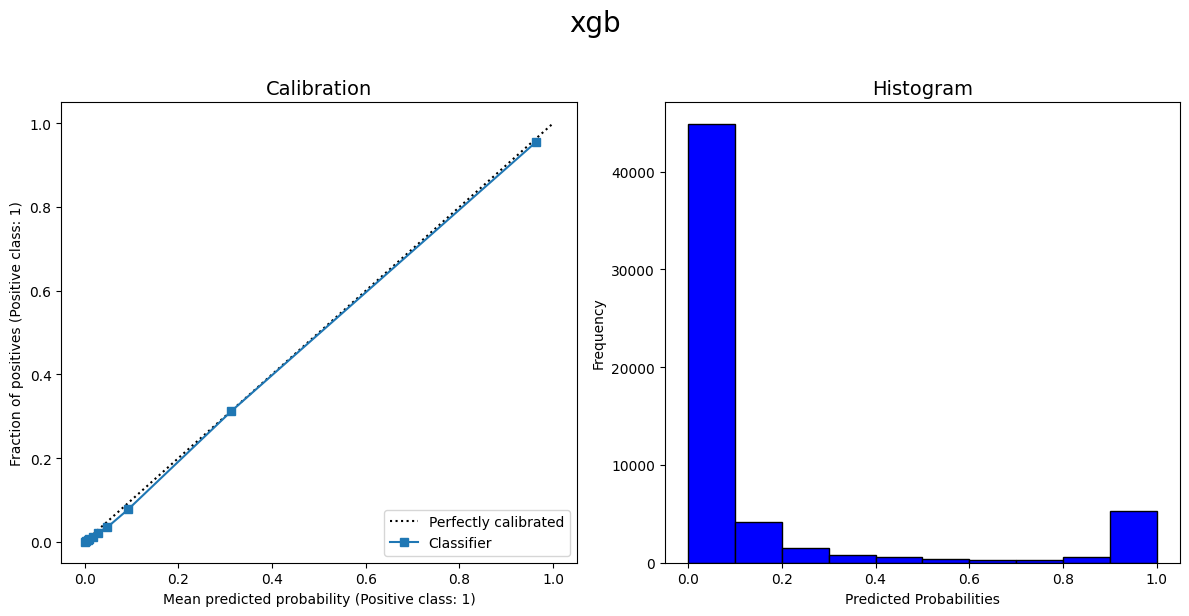

CPU times: user 12min 30s, sys: 2.94 s, total: 12min 33s
Wall time: 7min 8s


In [93]:
%%time

params_xgb = {

    'enable_categorical': True,
    'random_state': 1,
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'reg_lambda': 0.01,
    'max_depth': 4,
    'max_bin': 5000,
    'subsample': 0.95,
    'reg_alpha': 0.1,

}

model_3 = XGBClassifier(**params_xgb)

cross_validation(model_3, 'xgb')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">ExtraTrees</p>


🔹 Running Cross-Validation for: et

🔹 Preprocessing Data for: et
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.93369

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.93433

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.92886

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.93312

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.92482

📊 Final Metrics for et:
Mean ROC AUC: 0.93096
Std Dev ROC AUC: 0.00362


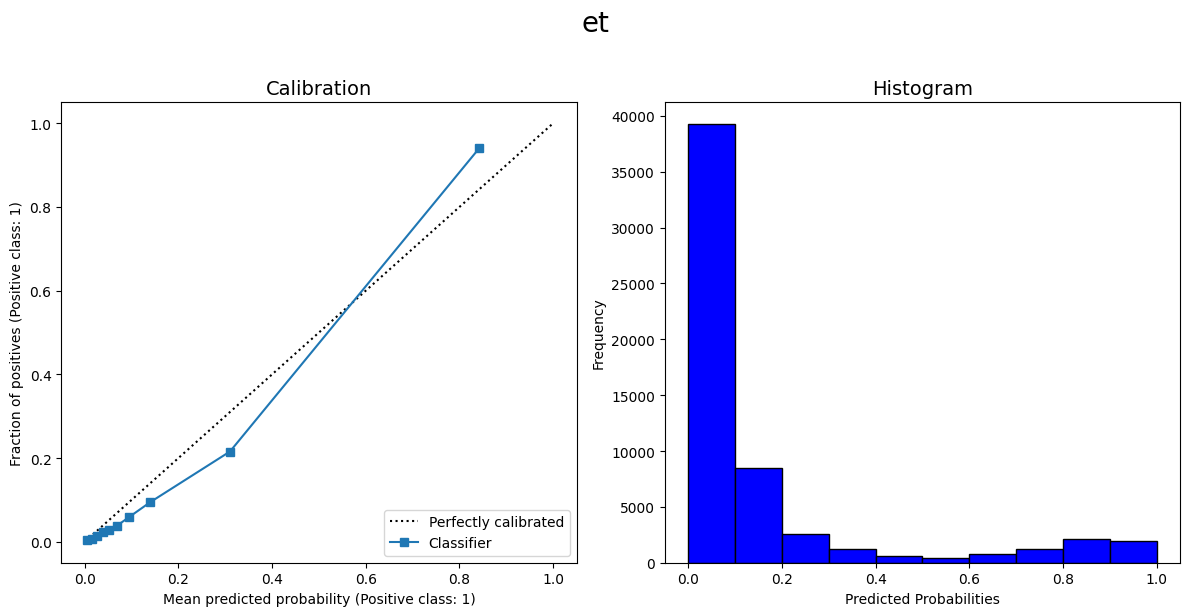

CPU times: user 2min 56s, sys: 1.14 s, total: 2min 57s
Wall time: 2min 58s


In [94]:
%%time

params_et = {

    'random_state': 1,
    'n_estimators': 470,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'criterion': 'log_loss',
}

model_4 = make_pipeline(TargetEncoder(), ExtraTreesClassifier(**params_et))

cross_validation(model_4, 'et')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Random Forest</p>


🔹 Running Cross-Validation for: rf

🔹 Preprocessing Data for: rf
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.94038

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.93927

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.93758

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.93657

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.93310

📊 Final Metrics for rf:
Mean ROC AUC: 0.93738
Std Dev ROC AUC: 0.00251


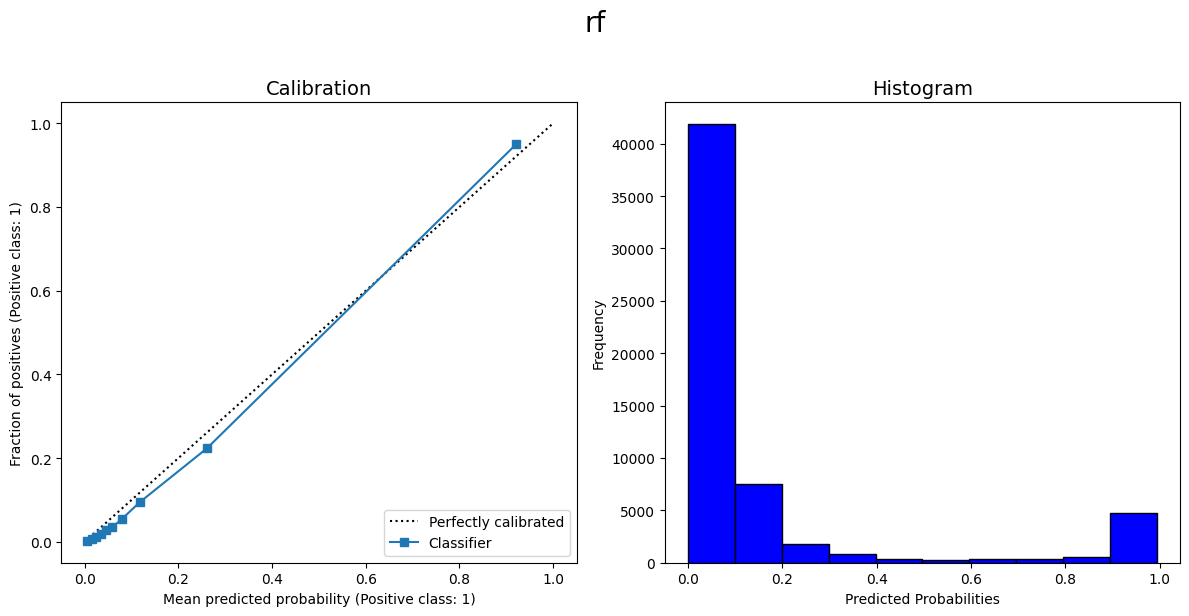

CPU times: user 4min 16s, sys: 329 ms, total: 4min 16s
Wall time: 4min 17s


In [95]:
%%time

params_rf = {

    'random_state': 1,
    'n_estimators': 450,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 960,
    'criterion': 'entropy',
}

model_5 = make_pipeline(TargetEncoder(), RandomForestClassifier(**params_rf))

cross_validation(model_5, 'rf')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">CatBoost</p>


🔹 Running Cross-Validation for: cb

🔹 Preprocessing Data for: cb
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.96516

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.96253

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.96560

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.96513

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.96273

📊 Final Metrics for cb:
Mean ROC AUC: 0.96423
Std Dev ROC AUC: 0.00132


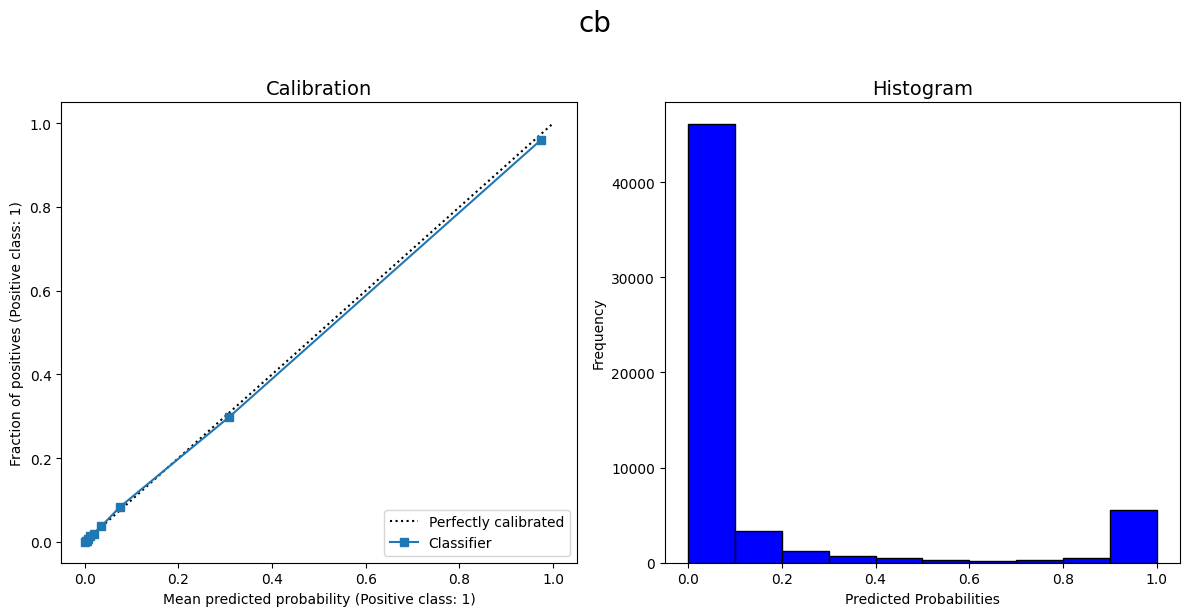

CPU times: user 1h 2min 30s, sys: 59.8 s, total: 1h 3min 30s
Wall time: 37min 26s


In [96]:
%%time

params_cb = {

    'verbose': False,
    'random_state': 1,
    'task_type': 'CPU',
    'cat_features' : test.columns.tolist(),
    'min_data_in_leaf': 5,
    'n_estimators': 1800,
    'random_strength': 0.79,
    'depth': 8,
    'bagging_temperature': 0.6,
    'l2_leaf_reg': 4,
    'rsm': 0.6,
}

model_6 = CatBoostClassifier(**params_cb)

cross_validation(model_6, 'cb')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">KNeighbors</p>


🔹 Running Cross-Validation for: knn

🔹 Preprocessing Data for: knn
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.91069

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.91085

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.90889

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.90782

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.90227

📊 Final Metrics for knn:
Mean ROC AUC: 0.90810
Std Dev ROC AUC: 0.00313


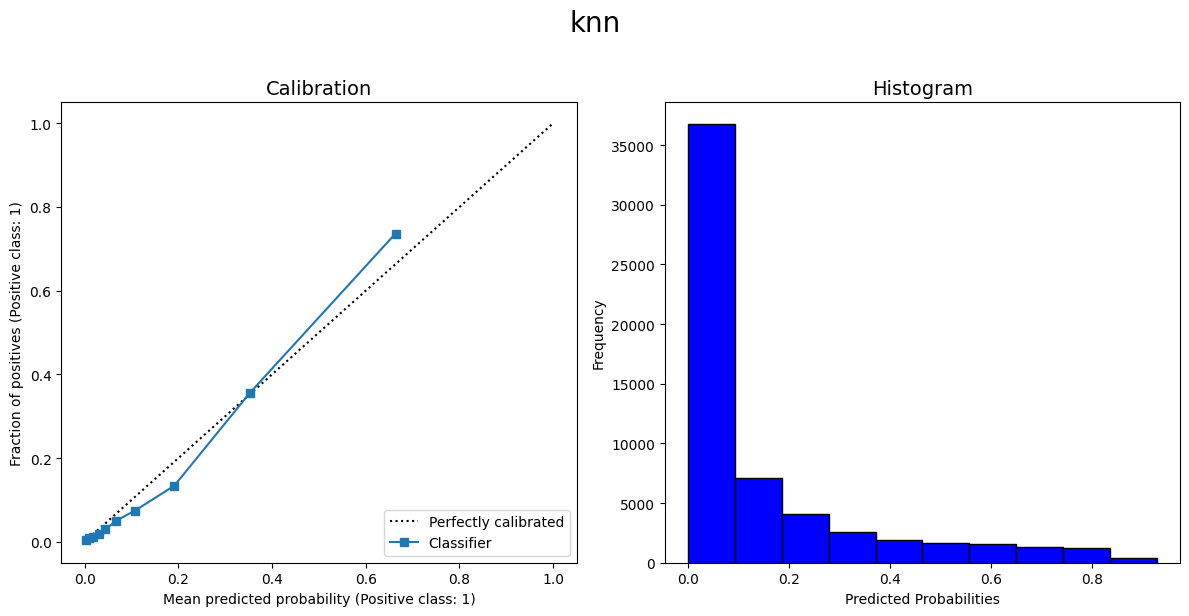

CPU times: user 43.5 s, sys: 1.22 s, total: 44.7 s
Wall time: 44.7 s


In [97]:
%%time

model_7 = make_pipeline(TargetEncoder(), KNeighborsClassifier(n_neighbors=185,
                                                              metric='manhattan',
                                                              weights='distance'))

cross_validation(model_7, 'knn')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">MLP</p>


🔹 Running Cross-Validation for: mlp

🔹 Preprocessing Data for: mlp
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.92779

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.92109

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.92464

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.92440

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.92018

📊 Final Metrics for mlp:
Mean ROC AUC: 0.92362
Std Dev ROC AUC: 0.00273


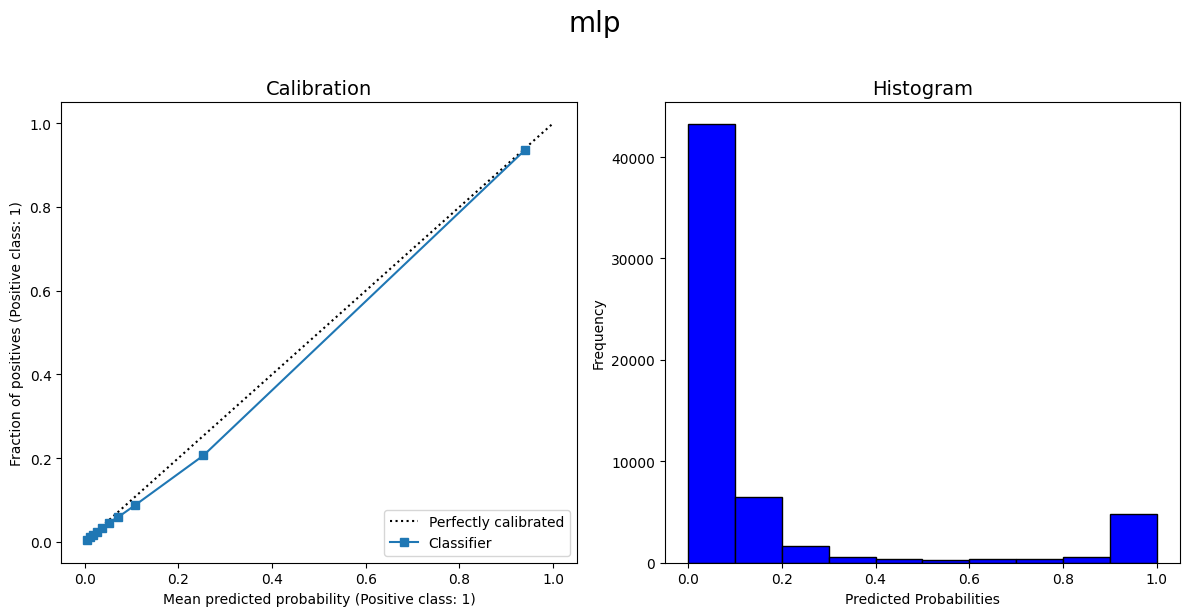

CPU times: user 3min 34s, sys: 974 ms, total: 3min 35s
Wall time: 3min 36s


In [98]:
%%time

params_mlp = {

    'random_state': 1,
    'hidden_layer_sizes': (32, 3),

}

model_8 = make_pipeline(TargetEncoder(), StandardScaler(), MLPClassifier(**params_mlp))

cross_validation(model_8, 'mlp')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Goss GOSS (Gradient-based One-Side Sampling) is a variant of LightGBM that focuses on improving efficiency by selecting only the most informative data points during training.</p>


🔹 Running Cross-Validation for: goss

🔹 Preprocessing Data for: goss
✅ Data Preprocessed: X shape=(58645, 11), y shape=(58645,)

➡️ Training Fold 1/5
✔️ Fold 1 ROC AUC: 0.96559

➡️ Training Fold 2/5
✔️ Fold 2 ROC AUC: 0.96407

➡️ Training Fold 3/5
✔️ Fold 3 ROC AUC: 0.96563

➡️ Training Fold 4/5
✔️ Fold 4 ROC AUC: 0.96482

➡️ Training Fold 5/5
✔️ Fold 5 ROC AUC: 0.96401

📊 Final Metrics for goss:
Mean ROC AUC: 0.96482
Std Dev ROC AUC: 0.00070


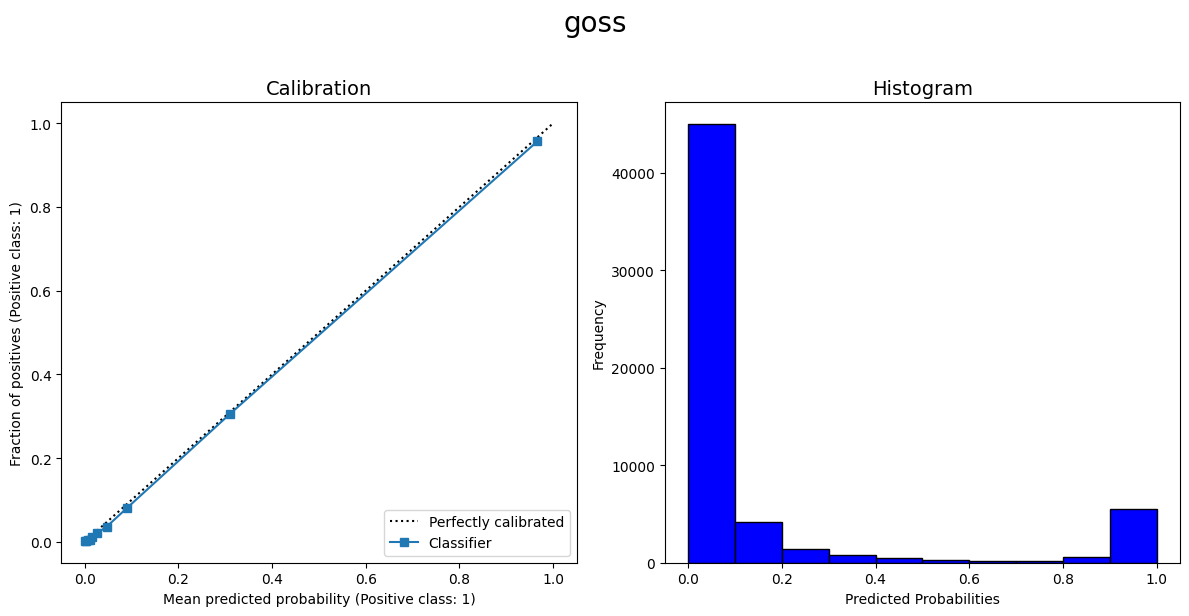

CPU times: user 5min 56s, sys: 1.14 s, total: 5min 57s
Wall time: 5min 59s


In [99]:
%%time

params_goss = {

    'verbose': -1,
    'random_state': 1,
    'data_sample_strategy': 'goss',
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 17,
    'max_bin': 4000,
}

model_9 = LGBMClassifier(**params_goss)

cross_validation(model_9, 'goss')

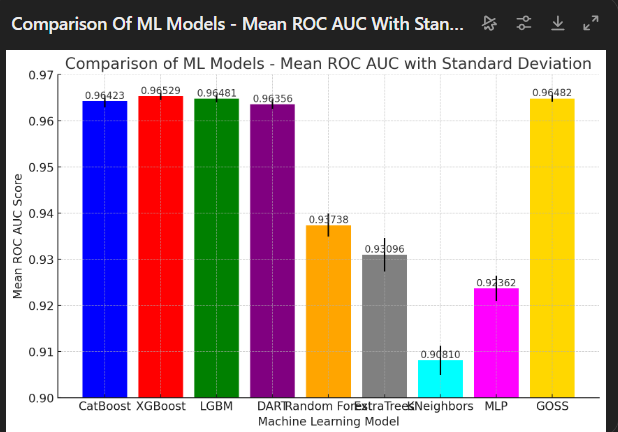

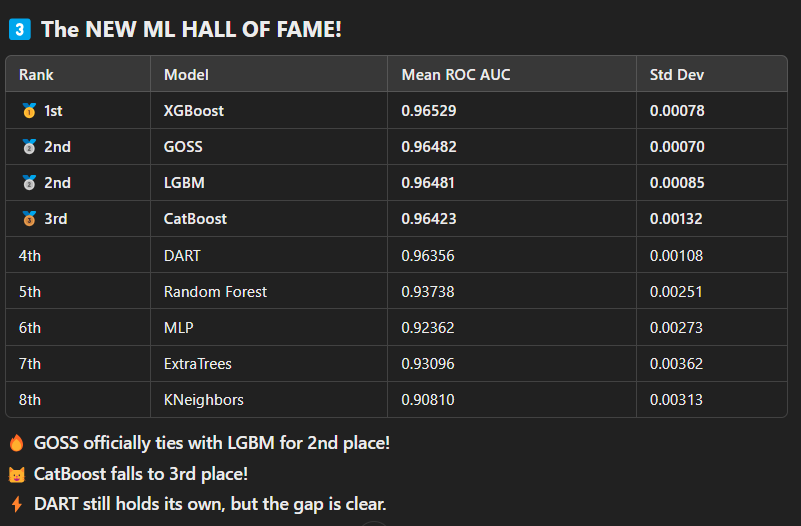

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">ECDF Plot (Empirical Cumulative Distribution Function)plot shows the cumulative proportion of predicted probabilities across models. It's useful for comparing how different models distribute their predictions for the positive class (1).</p>

<Axes: ylabel='Proportion'>

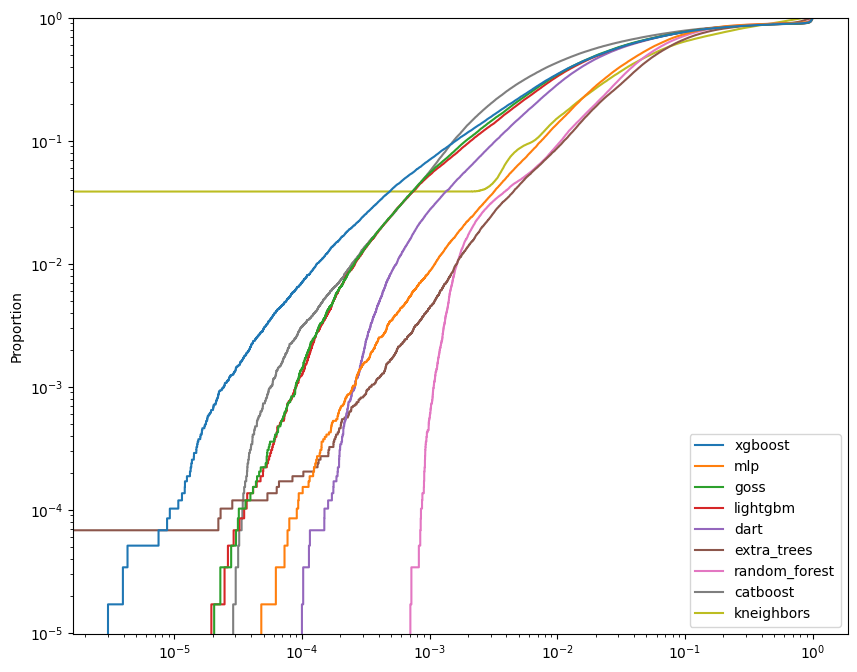

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xscale="log", yscale="log")
sns.ecdfplot(pd.DataFrame({'xgboost': oof['xgb'], 'mlp': oof['mlp'], 'goss': oof['goss'],
                           'lightgbm': oof['lgbm'], 'dart': oof['dart'],
                           'extra_trees': oof['et'], 'random_forest': oof['rf'],
                           'catboost': oof['cb'],'kneighbors': oof['knn']}), ax=ax)

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">(Logistic Regression) Ensemble</p>

In [101]:
ensemble_fold_scores = []
ensemble_test_preds = []

y_ensemble = train[target]
X_ensemble = pd.DataFrame(oof)
x_test_ensemble = pd.DataFrame(test_pred)

skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

for i, (train_index_ens, val_index_ens) in enumerate(skf.split(X_ensemble, y_ensemble)):

    X_train_ens, X_val_ens = X_ensemble.iloc[train_index_ens], X_ensemble.iloc[val_index_ens]
    y_train_ens, y_val_ens = y_ensemble[train_index_ens], y_ensemble[val_index_ens]

    lr = LogisticRegression().fit(X_train_ens, y_train_ens)

    ensemble_val_pred = lr.predict_proba(X_val_ens)[:, 1]

    ensemble_roc_auc_score = roc_auc_score(y_val_ens, ensemble_val_pred)
    ensemble_fold_scores.append(ensemble_roc_auc_score)

    print('Fold', i, '==> roc_auc_score (LR ensemble) is ==>', ensemble_roc_auc_score)

    ensemble_test_preds.append(lr.predict_proba(x_test_ensemble)[:, 1])

ensemble_test_preds = sum(ensemble_test_preds)/len(ensemble_test_preds)

print(f'\nCV roc_auc_score = {np.mean(ensemble_fold_scores):.5f}')
print(f'\nstd roc_auc_score = {np.std(ensemble_fold_scores):.5f}')

Fold 0 ==> roc_auc_score (LR ensemble) is ==> 0.9634559095349414
Fold 1 ==> roc_auc_score (LR ensemble) is ==> 0.964328843059482
Fold 2 ==> roc_auc_score (LR ensemble) is ==> 0.965155820181885
Fold 3 ==> roc_auc_score (LR ensemble) is ==> 0.9644896309379452
Fold 4 ==> roc_auc_score (LR ensemble) is ==> 0.9644589139644957

CV roc_auc_score = 0.96438

std roc_auc_score = 0.00054


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Hill climbing</p>

In [102]:
hc_test, hc_oof = climb_hill(train=train, target=target, objective='maximize',
                             eval_metric=partial(roc_auc_score),oof_pred_df= X_ensemble,
                             test_pred_df= x_test_ensemble,plot_hill=True,plot_hist=False,
                             precision=0.001,negative_weights=True,return_oof_preds=True)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (9 total): 

xgb:  0.96528 (best solo model)
goss: 0.96481
lgbm: 0.96480
cb:   0.96419
dart: 0.96355
rf:   0.93732
et:   0.93088
mlp:  0.92350
knn:  0.90807

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: cb | Best weight: 0.445 | Best roc_auc_score: 0.96699
Iteration: 2 | Model added: dart | Best weight: 0.126 | Best roc_auc_score: 0.96706
Iteration: 3 | Model added: et | Best weight: 0.020 | Best roc_auc_score: 0.96709
Iteration: 4 | Model added: rf | Best weight: -0.022 | Best roc_auc_score: 0.96712
Iteration: 5 | Model added: mlp | Best weight: -0.012 | Best roc_auc_score: 0.96713
Iteration: 6 | Model added: goss | Best weight: -0.050 | Best roc_auc_score: 0.96713
Iteration: 7 | Model added: knn | Best weight: 0.003 | Best roc_auc_score: 0.96713
Iteration: 8 | Model added: lgbm | Best weight: 0.004 | Best roc_auc_score: 0.96713


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Submission</p>

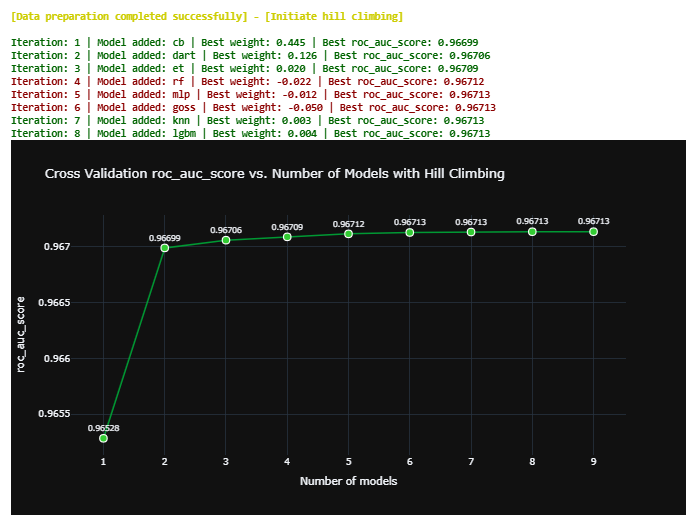

In [103]:
sample_submission[target] = hc_test
sample_submission.head()

,id,loan_status
0,58645,0.998291
1,58646,0.090011
2,58647,0.420149
3,58648,0.026853
4,58649,0.093197


In [104]:
sample_submission.to_csv('submission.csv', index=False)